In [1]:
import os
import sys

problems_path = os.path.abspath(os.path.join('test_problems'))
solver_path = os.path.abspath(os.path.join('../zfista'))
fig_path = os.path.abspath(os.path.join('./figs'))
data_path = os.path.abspath(os.path.join('./data'))
os.makedirs(fig_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
if problems_path not in sys.path:
    sys.path.append(problems_path)
if solver_path not in sys.path:
    sys.path.append(solver_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import csv

rc('text', usetex=True)

In [3]:
from zfista import minimize_proximal_gradient
from problems import JOS1, JOS1_L1, SD, FDS, FDS_CONSTRAINED
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [4]:
from fractions import Fraction

nesterov_ratios_f = [
    (0, 0),
    (0, Fraction(1, 8)),
    (0, Fraction(1, 4)),
    (Fraction(1, 6), Fraction(1, 144)),
    (Fraction(1, 6), Fraction(37, 288)),
    (Fraction(1, 6), Fraction(1, 4)),
    (Fraction(1, 4), Fraction(1, 64)),
    (Fraction(1, 4), Fraction(17, 128)),
    (Fraction(1, 4), Fraction(1, 4)),
    (Fraction(1, 2), Fraction(1, 16)),
    (Fraction(1, 2), Fraction(5, 32)),
    (Fraction(1, 2), Fraction(1, 4)),
    (Fraction(3, 4), Fraction(9, 64)),
    (Fraction(3, 4), Fraction(25, 128)),
    (Fraction(3, 4), Fraction(1, 4)),
]
nesterov_ratios = list(map(lambda t: tuple(map(float, t)), nesterov_ratios_f))


def generate_start_points(low, high, n_dims, n_samples=1000):
    return [
        np.random.uniform(low=low, high=high, size=n_dims)
        for _ in range(n_samples)
    ]


def run(problem,
        start_points,
        tol=1e-5,
        nesterov=False,
        nesterov_ratio=(0, 0.25),
        n_jobs=-1,
        verbose=False):
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(minimize_proximal_gradient)(problem.f,
                                            problem.g,
                                            problem.jac_f,
                                            problem.prox_wsum_g,
                                            x0,
                                            tol=tol,
                                            nesterov=nesterov,
                                            nesterov_ratio=nesterov_ratio,
                                            return_all=False,
                                            verbose=verbose)
        for x0 in start_points)
    return results


def show_Pareto_front(problem,
                      results,
                      s=15,
                      alpha=0.75,
                      fname=None,
                      elev=15,
                      azim=130,
                      linewidths=.1):
    fig = plt.figure(figsize=(7.5, 12.5), dpi=100)
    if problem.m_dims == 2:
        axs = [fig.add_subplot(5, 3, i + 1) for i in range(15)]
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    if problem.m_dims == 3:
        axs = [
            fig.add_subplot(5, 3, i + 1, projection='3d', clip_on=True)
            for i in range(15)
        ]
        for i in range(15):
            axs[i].view_init(elev=elev, azim=azim)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=0.6)
    for i, result in tqdm(enumerate(results)):
        ax = axs[i]
        ax.set_title('$(a, b) = (' + ','.join(map(str, nesterov_ratios_f[i])) +
                     ')$')
        for result_k in tqdm(result):
            F_pareto = result_k.fun
            ax.scatter(*F_pareto,
                       color="#2980b9",
                       marker=".",
                       s=s,
                       alpha=alpha,
                       linewidths=linewidths)
        ax.set_xlabel(r'$F_1$', fontsize=10)
        ax.set_ylabel(r'$F_2$', fontsize=10)
        ax.tick_params(labelsize=8)
        if problem.m_dims == 3:
            ax.set_zlabel(r'$F_3$', fontsize=10)
    fig.tight_layout()
    if fname is not None:
        plt.savefig(fig_path + '/' + fname, bbox_inches='tight')


def get_stats(results):
    nits = [result.nit for result in results]
    nit_internals = [result.nit_internal for result in results]
    execution_times = [result.execution_time for result in results]
    stats = {
        'nit': {
            'mean': np.mean(nits),
            'std': np.std(nits),
            'max': np.max(nits)
        },
        'nit_internal': {
            'mean': np.mean(nit_internals),
            'std': np.std(nit_internals),
            'max': np.max(nit_internals)
        },
        'total_time': {
            'mean': np.mean(execution_times),
            'std': np.std(execution_times),
            'max': np.max(execution_times)
        }
    }
    return stats

## JOS1
Minimize
$$
f_1(x) = \frac{1}{n} \| x \|_2^2, \quad f_2(x) = \frac{1}{n} \| x - 2\|_2^2
$$
subject to $x \in \mathbf{R^n}$.

In [5]:
n_dims = 50
problem_JOS1 = JOS1(n_dims=n_dims)
start_points_JOS1 = generate_start_points(low=-2, high=4, n_dims=n_dims)

CPU times: user 11.9 ms, sys: 2.23 ms, total: 14.2 ms
Wall time: 22.6 ms


In [6]:
results_JOS1 = [
    run(problem_JOS1,
        start_points_JOS1,
        nesterov=True,
        nesterov_ratio=nesterov_ratio)
    for nesterov_ratio in tqdm(nesterov_ratios)
]

  0%|          | 0/15 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.6min
/Users/zalgo/Documents/GitHub/acc_PGM_for_multiobjective_optimization/venv/lib/python3.9/site-packages/scipy/optimize/

[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  8.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | 

[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:  8.4min
[Paralle

[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  6.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  9.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | 

[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:  7.5min


CPU times: user 22.1 s, sys: 3.89 s, total: 26 s
Wall time: 2h 28min 3s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  7.8min finished


### Complexity

In [7]:
import pprint

stats_JOS1 = {
    ','.join(map(str, nesterov_ratios_f[i])): get_stats(results_JOS1[i])
    for i in range(len(nesterov_ratios))
}
pprint.pprint(stats_JOS1)

with open(data_path + '/JOS1_ab.csv', 'w') as f:
    writer = csv.writer(f, escapechar=' ', quoting=csv.QUOTE_NONE)
    for k, v in stats_JOS1.items():
        writer.writerow(
            [k,
             round(v['total_time']['mean'], 3),
             round(v['nit']['mean'], 3)])

{'0,0': {'nit': {'max': 97, 'mean': 97.0, 'std': 0.0},
         'nit_internal': {'max': 1940,
                          'mean': 1425.649,
                          'std': 102.4005068298004},
         'total_time': {'max': 14.94438123703003,
                        'mean': 6.442267942905426,
                        'std': 1.4142029714705993}},
 '0,1/4': {'nit': {'max': 65, 'mean': 65.0, 'std': 0.0},
           'nit_internal': {'max': 1300,
                            'mean': 954.342,
                            'std': 66.33833760353059},
           'total_time': {'max': 8.547248125076294,
                          'mean': 4.206672308444976,
                          'std': 0.640413453986176}},
 '0,1/8': {'nit': {'max': 112, 'mean': 81.217, 'std': 2.584552379039744},
           'nit_internal': {'max': 2240,
                            'mean': 1193.92,
                            'std': 106.11720689878716},
           'total_time': {'max': 10.89492416381836,
                          'mea

0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 4min, sys: 3.88 s, total: 4min 4s
Wall time: 4min 4s


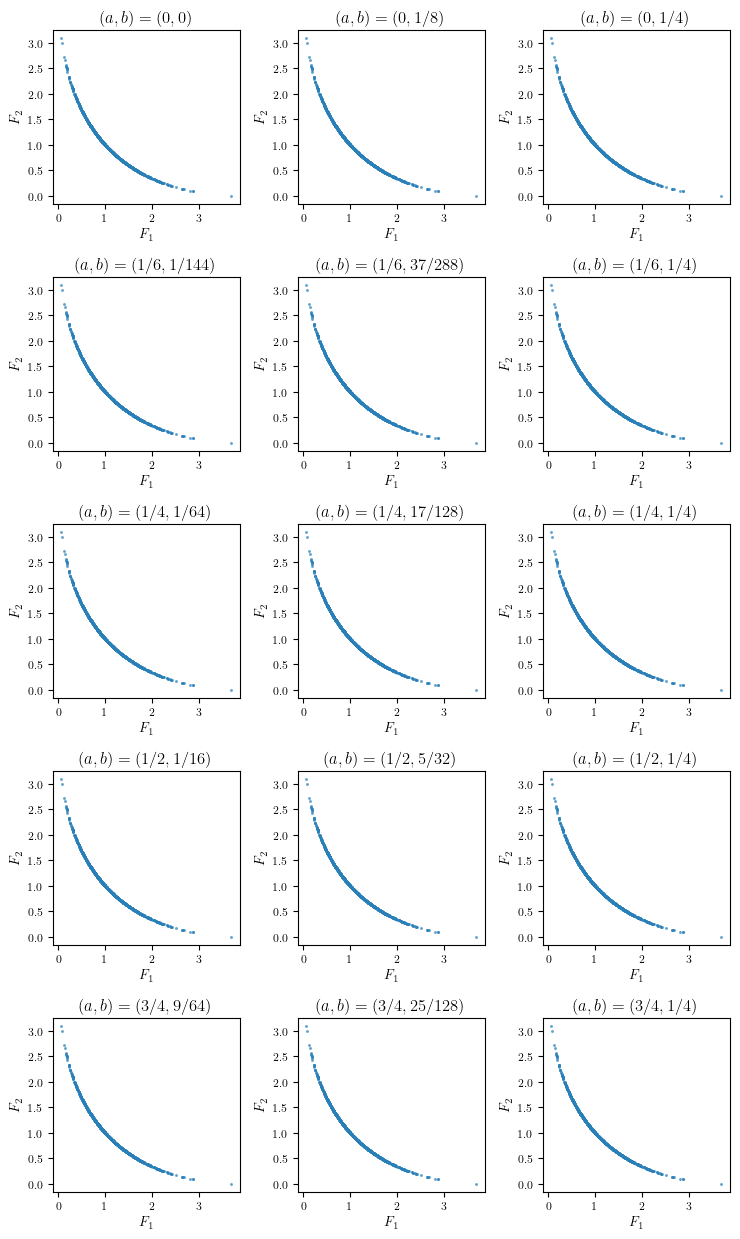

In [8]:
show_Pareto_front(problem_JOS1, results_JOS1, fname='JOS1_ab.pdf')

## JOS1 + $\ell_1$ penalty
Minimize
$$
F_1(x) = \frac{1}{n} \| x \|_2^2 + \frac{1}{n} \|x\|_1, \quad F_2(x) = \frac{1}{n} \| x - 2\|_2^2 + \frac{1}{2n} \|x - 1\|_1
$$
subject to $x \in \mathbf{R}^n$.

In [9]:
n_dims = 50
problem_JOS1_L1 = JOS1_L1(n_dims=n_dims,
                          l1_ratios=(1 / n_dims, 1 / n_dims / 2))
start_points_JOS1_L1 = generate_start_points(low=-2, high=4, n_dims=n_dims)

CPU times: user 10 ms, sys: 2.46 ms, total: 12.5 ms
Wall time: 10.6 ms


In [10]:
results_JOS1_L1 = [
    run(problem_JOS1_L1,
        start_points_JOS1_L1,
        nesterov=True,
        nesterov_ratio=nesterov_ratio)
    for nesterov_ratio in tqdm(nesterov_ratios)
]

  0%|          | 0/15 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/zalgo/Documents/GitHub/acc_PGM_for_multiobjective_optimization/venv/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/zalgo/Documents/GitHub/acc_PGM_for_multiobjective_optimization/venv/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/zalgo/Documents/GitHub/acc_PGM_for_multiobjective_optimization/venv/lib/python3

[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 23.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | 

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  5.9min
[Paralle

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 10.1min
[Paralle

[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.7min
[Paralle

[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed: 11.3min


CPU times: user 22.4 s, sys: 3.92 s, total: 26.3 s
Wall time: 4h 32min 47s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 11.9min finished


### Complexity

In [11]:
stats_JOS1_L1 = {
    ','.join(map(str, nesterov_ratios_f[i])): get_stats(results_JOS1_L1[i])
    for i in range(len(nesterov_ratios))
}
pprint.pprint(stats_JOS1_L1)

with open(data_path + '/JOS1_L1_ab.csv', 'w') as f:
    writer = csv.writer(f, escapechar=' ', quoting=csv.QUOTE_NONE)
    for k, v in stats_JOS1_L1.items():
        writer.writerow(
            [k,
             round(v['total_time']['mean'], 3),
             round(v['nit']['mean'], 3)])

{'0,0': {'nit': {'max': 186, 'mean': 157.512, 'std': 16.3141612104331},
         'nit_internal': {'max': 3446,
                          'mean': 2378.271,
                          'std': 331.07050541991805},
         'total_time': {'max': 21.726453065872192,
                        'mean': 10.73323300433159,
                        'std': 1.8907491068593971}},
 '0,1/4': {'nit': {'max': 187, 'mean': 161.734, 'std': 16.993917853161467},
           'nit_internal': {'max': 3434,
                            'mean': 2438.932,
                            'std': 315.208999516194},
           'total_time': {'max': 21.59866499900818,
                          'mean': 11.12169546532631,
                          'std': 1.814884949086249}},
 '0,1/8': {'nit': {'max': 186, 'mean': 161.065, 'std': 16.62849286616198},
           'nit_internal': {'max': 3755,
                            'mean': 2428.512,
                            'std': 316.49933310514257},
           'total_time': {'max': 18.457965

0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 4min 1s, sys: 3.75 s, total: 4min 4s
Wall time: 4min 3s


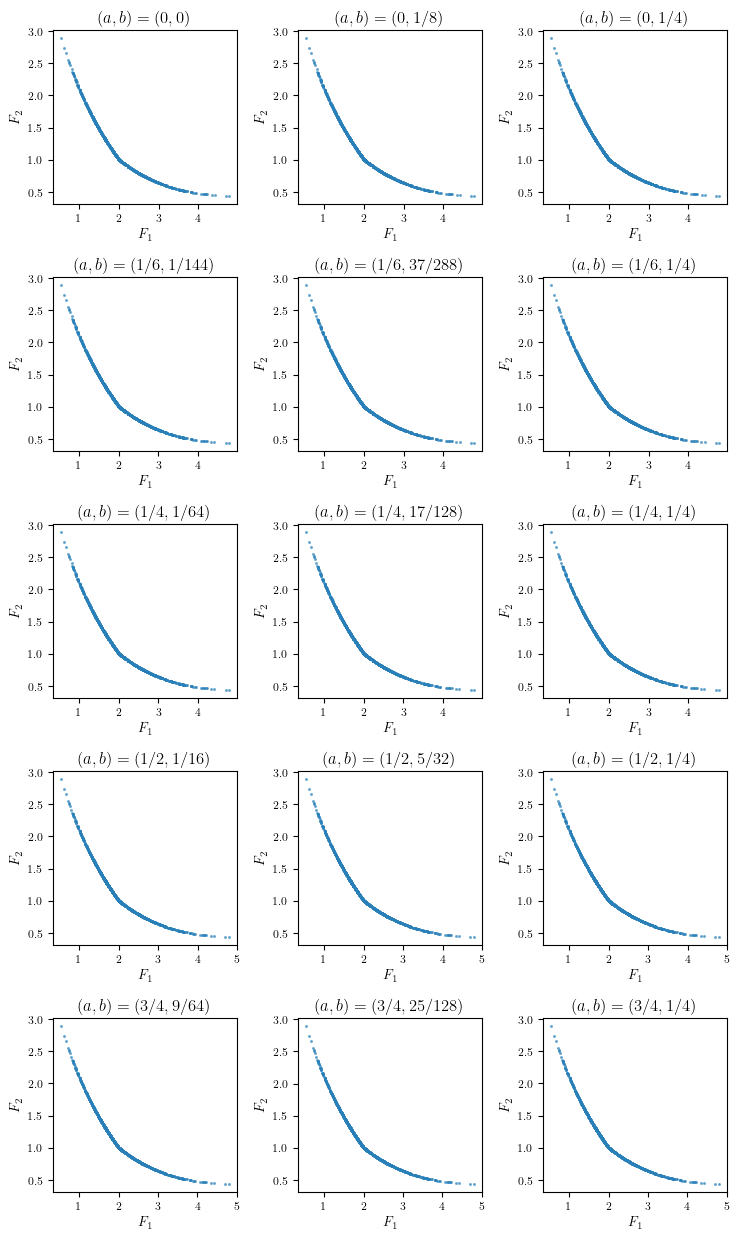

In [12]:
show_Pareto_front(problem_JOS1_L1, results_JOS1_L1, fname='JOS1_L1_ab.pdf')

## SD
Minimize
$$F_1(x) = 2 x_1 + \sqrt{2} x_2 + \sqrt{2} x_3 + x_4, \quad F_2(x) = \frac{2}{x_1} + \frac{2 \sqrt{2}}{x_2} + \frac{2 \sqrt{2}}{x_3} + \frac{2}{x_4}$$
subject to $(1, \sqrt{2}, \sqrt{2}, 1)^\top \le x \le (3, 3, 3, 3)^\top$.

In [13]:
problem_SD = SD()
start_points_SD = generate_start_points(low=problem_SD.lb,
                                        high=problem_SD.ub,
                                        n_dims=problem_SD.n_dims)

CPU times: user 24.5 ms, sys: 7.75 ms, total: 32.3 ms
Wall time: 26.2 ms


In [14]:
results_SD = [
    run(problem_SD,
        start_points_SD,
        nesterov=True,
        nesterov_ratio=nesterov_ratio)
    for nesterov_ratio in tqdm(nesterov_ratios)
]

  0%|          | 0/15 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  2.9min
[Paralle

[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.5min
[Paralle

[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:  4.7min
[Paralle

[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 con

CPU times: user 25.1 s, sys: 4.04 s, total: 29.1 s
Wall time: 1h 31min 18s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.1min finished


### Complexity

In [15]:
stats_SD = {
    ','.join(map(str, nesterov_ratios_f[i])): get_stats(results_SD[i])
    for i in range(len(nesterov_ratios))
}
pprint.pprint(stats_SD)

with open(data_path + '/SD_ab.csv', 'w') as f:
    writer = csv.writer(f, escapechar=' ', quoting=csv.QUOTE_NONE)
    for k, v in stats_SD.items():
        writer.writerow(
            [k,
             round(v['total_time']['mean'], 3),
             round(v['nit']['mean'], 3)])

{'0,0': {'nit': {'max': 54, 'mean': 36.888, 'std': 6.910966357898149},
         'nit_internal': {'max': 918,
                          'mean': 565.327,
                          'std': 112.41957156563086},
         'total_time': {'max': 6.01006293296814,
                        'mean': 3.8097551724910734,
                        'std': 0.6939221433365924}},
 '0,1/4': {'nit': {'max': 56, 'mean': 37.851, 'std': 7.058385013584907},
           'nit_internal': {'max': 914,
                            'mean': 580.043,
                            'std': 114.92429312812848},
           'total_time': {'max': 6.200822830200195,
                          'mean': 3.9070519654750826,
                          'std': 0.6966109972511082}},
 '0,1/8': {'nit': {'max': 55, 'mean': 37.415, 'std': 6.96554197460614},
           'nit_internal': {'max': 918,
                            'mean': 573.402,
                            'std': 113.59722001880152},
           'total_time': {'max': 11.205124139785767,

0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 3min 52s, sys: 3.63 s, total: 3min 55s
Wall time: 3min 56s


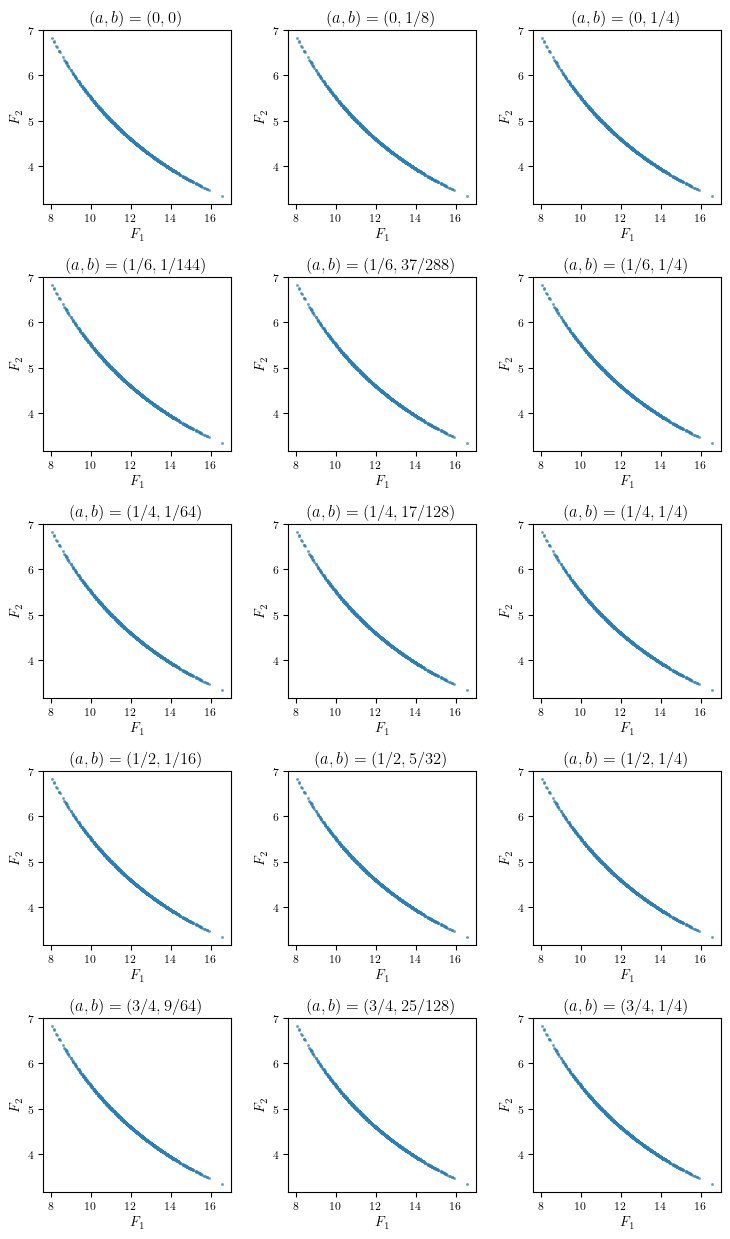

In [16]:
%matplotlib inline
show_Pareto_front(problem_SD, results_SD, fname='SD_ab.pdf')

## FDS
Minimize
$$F_1(x) = \frac{1}{n^2} \sum_{i = 1}^n i (x_i - i)^4, \quad F_2(x) = \exp \left( \sum_{i = 1}^n \frac{x_i}{n} \right) + \|x\|_2^2, \quad F_3(x) = \frac{1}{n(n + 1)} \sum_{i = 1}^n i (n - i + 1) \exp (- x_i)$$
subject to $x \in \mathbf{R}^n$.

In [17]:
n_dims = 10
problem_FDS = FDS(n_dims=n_dims)
start_points_FDS = generate_start_points(low=-2, high=2, n_dims=n_dims)

CPU times: user 8.55 ms, sys: 3.49 ms, total: 12 ms
Wall time: 9.47 ms


In [18]:
results_FDS = [
    run(problem_FDS,
        start_points_FDS,
        nesterov=True,
        nesterov_ratio=nesterov_ratio)
    for nesterov_ratio in tqdm(nesterov_ratios)
]

  0%|          | 0/15 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed: 19.9min
[Paralle

[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 30.3min
[Paralle

[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed: 35.7min
[Paralle

[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 28.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | 

CPU times: user 25.3 s, sys: 4.5 s, total: 29.8 s
Wall time: 11h 32min 53s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 28.8min finished


### Complexity

In [19]:
stats_FDS = {
    ','.join(map(str, nesterov_ratios_f[i])): get_stats(results_FDS[i])
    for i in range(len(nesterov_ratios))
}
pprint.pprint(stats_FDS)

with open(data_path + '/FDS_ab.csv', 'w') as f:
    writer = csv.writer(f, escapechar=' ', quoting=csv.QUOTE_NONE)
    for k, v in stats_FDS.items():
        writer.writerow(
            [k,
             round(v['total_time']['mean'], 3),
             round(v['nit']['mean'], 3)])

{'0,0': {'nit': {'max': 425, 'mean': 204.438, 'std': 64.96254425436246},
         'nit_internal': {'max': 15208,
                          'mean': 7215.168,
                          'std': 2236.656568133785},
         'total_time': {'max': 63.261374950408936,
                        'mean': 29.239688552618027,
                        'std': 9.122627707371715}},
 '0,1/4': {'nit': {'max': 458, 'mean': 214.934, 'std': 67.17975620676216},
           'nit_internal': {'max': 15718,
                            'mean': 7567.118,
                            'std': 2328.1277551019402},
           'total_time': {'max': 61.993821144104004,
                          'mean': 30.56476167488098,
                          'std': 9.446371502210283}},
 '0,1/8': {'nit': {'max': 424, 'mean': 210.595, 'std': 65.64861746449806},
           'nit_internal': {'max': 14461,
                            'mean': 7421.293,
                            'std': 2267.4281380345883},
           'total_time': {'max': 60.5

0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 4min 37s, sys: 6.96 s, total: 4min 44s
Wall time: 4min 43s


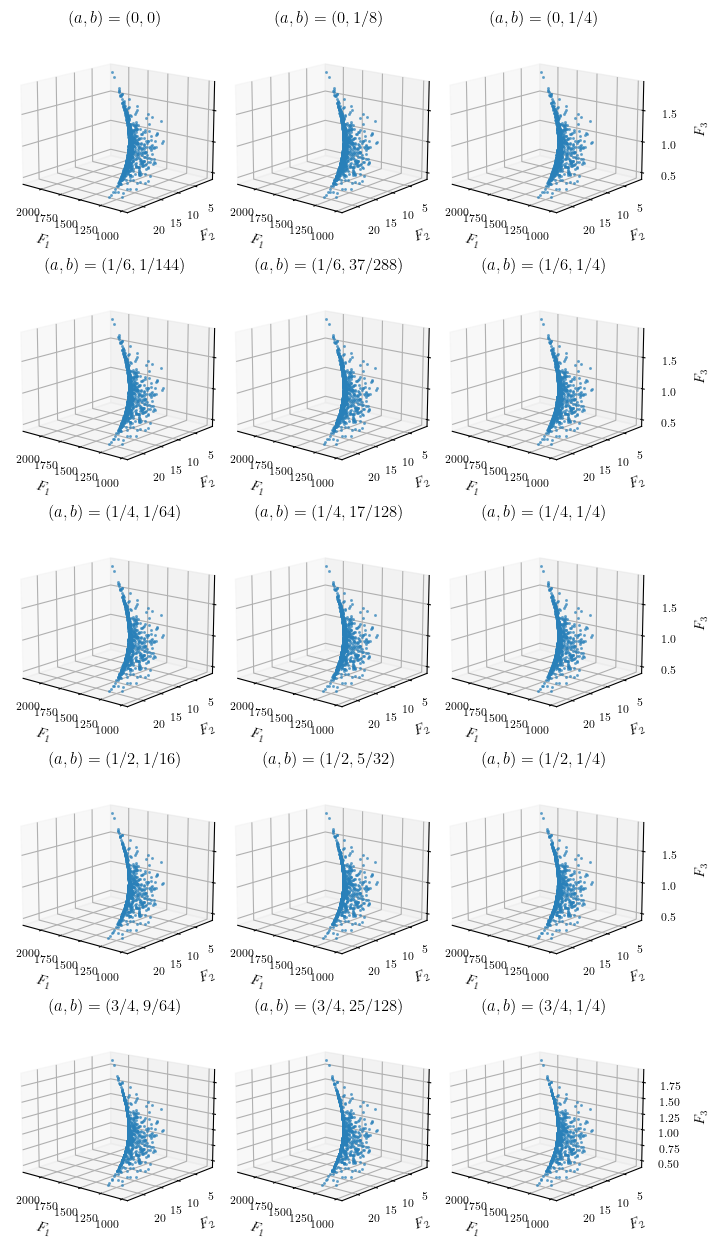

In [20]:
%matplotlib inline
show_Pareto_front(problem_FDS, results_FDS, fname='FDS_ab.pdf')

## FDS CONSTRAINED
Minimize
$$F_1(x) = \frac{1}{n^2} \sum_{i = 1}^n i (x_i - i)^4, \quad F_2(x) = \exp \left( \sum_{i = 1}^n \frac{x_i}{n} \right) + \|x\|_2^2, \quad F_3(x) = \frac{1}{n(n + 1)} \sum_{i = 1}^n i (n - i + 1) \exp (- x_i)$$
subject to $x \in \mathbf{R}_+^n$.

In [21]:
n_dims = 10
problem_FDS_CONSTRAINED = FDS_CONSTRAINED(n_dims=n_dims)
start_points_FDS_CONSTRAINED = generate_start_points(low=0,
                                                     high=2,
                                                     n_dims=n_dims)

CPU times: user 5.72 ms, sys: 1.71 ms, total: 7.43 ms
Wall time: 5.89 ms


In [22]:
results_FDS_CONSTRAINED = [
    run(problem_FDS_CONSTRAINED,
        start_points_FDS_CONSTRAINED,
        nesterov=True,
        nesterov_ratio=nesterov_ratio)
    for nesterov_ratio in tqdm(nesterov_ratios)
]

  0%|          | 0/15 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 14

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed: 25.8min
[Paralle

[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 35.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed: 40.8min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 43.4min
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed: 46.1min
[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed: 48.9min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed: 52.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 55.0min
[Paralle

[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed: 36.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed: 39.8min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 41.5min
[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed: 43.6min
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed: 45.8min
[Paralle

[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 35.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | 

CPU times: user 25.9 s, sys: 4.84 s, total: 30.7 s
Wall time: 15h 51min 53s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 35.7min finished


In [23]:
stats_FDS_CONSTRAINED = {','.join(map(str, nesterov_ratios_f[i])): get_stats(
    results_FDS_CONSTRAINED[i]) for i in range(len(nesterov_ratios))}
pprint.pprint(stats_FDS_CONSTRAINED)

with open(data_path + '/FDS_CONSTRAINED_ab.csv', 'w') as f:
    writer = csv.writer(f, escapechar=' ', quoting=csv.QUOTE_NONE)
    for k, v in stats_FDS_CONSTRAINED.items():
        writer.writerow([k, round(v['total_time']['mean'], 3),
                        round(v['nit']['mean'], 3)])

{'0,0': {'nit': {'max': 532, 'mean': 259.508, 'std': 86.74177733941126},
         'nit_internal': {'max': 17278,
                          'mean': 9127.257,
                          'std': 2722.1529275466874},
         'total_time': {'max': 73.12641310691833,
                        'mean': 37.34500452136994,
                        'std': 11.15371395982526}},
 '0,1/4': {'nit': {'max': 531, 'mean': 263.911, 'std': 86.37866101648022},
           'nit_internal': {'max': 17776,
                            'mean': 9286.23,
                            'std': 2708.3767055378394},
           'total_time': {'max': 77.08447504043579,
                          'mean': 37.940253603219986,
                          'std': 10.9881588370778}},
 '0,1/8': {'nit': {'max': 531, 'mean': 261.522, 'std': 86.98074221343481},
           'nit_internal': {'max': 17883,
                            'mean': 9195.038,
                            'std': 2730.2995983144415},
           'total_time': {'max': 75.8685

0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 4min 35s, sys: 6.38 s, total: 4min 41s
Wall time: 4min 39s


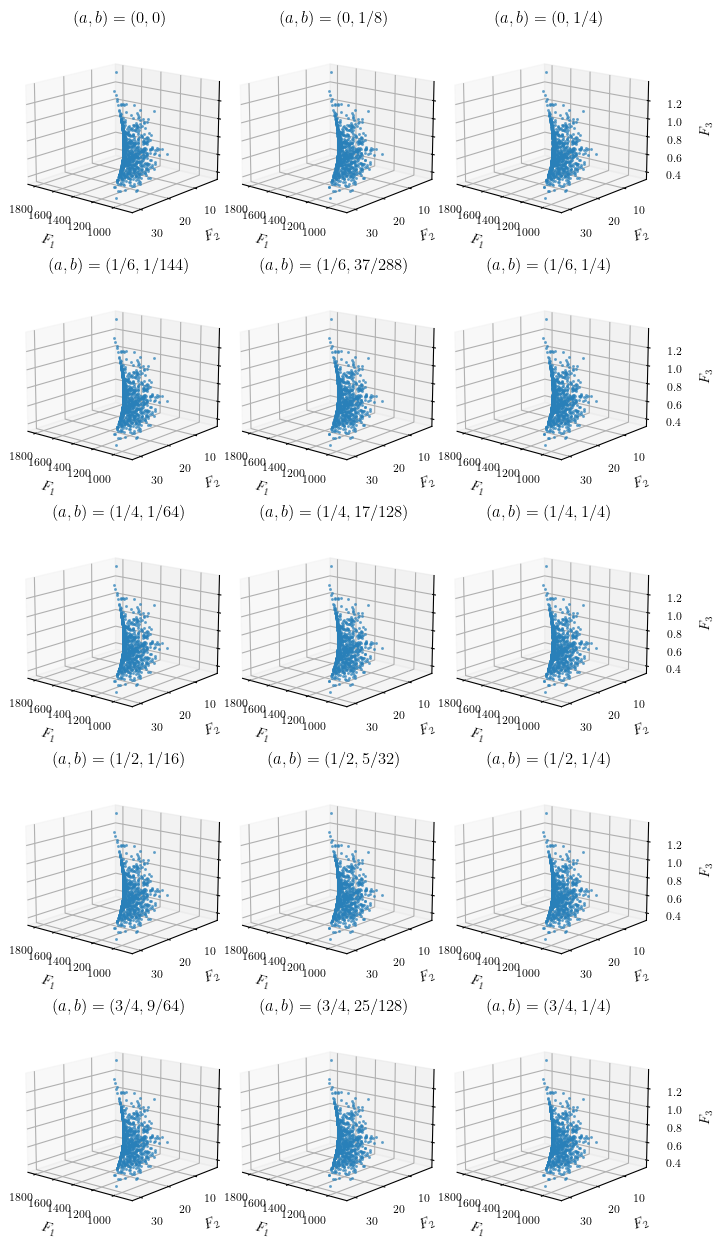

In [24]:
%matplotlib inline
show_Pareto_front(problem_FDS_CONSTRAINED,
                  results_FDS_CONSTRAINED, fname='FDS_CONSTRAINED_ab.pdf')